# FITTING WITH PHOEBE 2

In [2]:
import numpy as np
import phoebe

Let's start by initializing our Bundle and setting the values of our fixed parameters.

In [3]:
b = phoebe.default_binary()

b['period@orbit'] = 3.1415926
b['t0'] = 245357.0 + 3.1415926

Let's add a light curve dataset and the observations associated with it.

In [4]:
lcdata = np.loadtxt('data/lc.kepler.data', delimiter=' ')

In [5]:
b.add_dataset('lc', times = lcdata[:,0], fluxes=lcdata[:,1], sigmas=lcdata[:,2], passband='Kepler:mean')

<ParameterSet: 36 parameters | contexts: constraint, dataset, compute>

There are a lot of data points in our light curve:

In [6]:
len(lcdata)

6417

so let's instead provide a smaller set of phases that we want our phoebe model to be computed in (unless you're okay with waiting a long time):

In [7]:
b.flip_constraint('compute_phases', 'compute_times')
b.set_value('compute_phases', np.linspace(-0.5,0.5,50))

PHOEBE provides some functionality that let's you choose which parametrization you'd like to use. For example, you can have eccentricity and argument of periastron as your free parameters, or esinw and ecosw. By default, eccentricity and arg. of periastron are free and esinw and ecosw constrained, so if we want to fit esinw and ecosw, we need to tell PHOEBE to "flip" the constraints:

In [8]:
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

<ConstraintParameter: {per0@binary@component} = arctan2({esinw@binary@component}, {ecosw@binary@component}) (solar units) => 0.0 deg>

If we don't want to fit for the passband luminosity, but still ensure that our model is scaled to the observed flux, we can set pblum-mode to dataset-scaled and PHOEBE will handle that for us.

In [9]:
b['pblum_mode'] = 'dataset-scaled'

That's all of the prep work we need to do to fit our model!

To use any external optimizer, we need to provide the vector of parameters to fit and construct a function to be minimized. For the purposes of this example, let's adjust the inclination, esinw, ecosw, the sum and ratio of radii and temperature ratio. The function to be minimized in our case is chi2:

In [10]:
def chi2(param_values):
    (incl, esinw, ecosw, rsum, rratio, tratio) = param_values
    
    '''
    If some of the values are outside of the physical parameter space,
    setting the parameters or running compute will fail, so we need to catch
    and penalize those cases. Because some algorithms don't handle nans or infs
    we'll just use an arbitrarily large number. (1e12 in this case)
    '''
    
    try:
        b['esinw'] = esinw
        b['ecosw'] = ecosw
        b['incl@binary'] = incl
        # b['q'] = q
        b['requiv@primary'] = b['value@sma@binary']*rsum/(1.+rratio)
        b['requiv@secondary'] = b['value@sma@binary']*rsum*rratio/(1.+rratio)
        # b['teff@primary'] = teff1 
        b['teff@secondary'] = tratio*b['value@teff@primary']
        # b['pblum'] = pblum
        # b['l3'] = l3

        b.run_compute(irrad_method='none')
        fluxes_model = b['fluxes@model'].interp_value(times=lcdata[:,0])
        chi2 = 0.5*np.sum((fluxes_model-b['value@fluxes@lc01@dataset'])**2 / b['value@sigmas@lc01@dataset']**2 )
        print(param_values, chi2)
        return chi2

    except:
        
        print(param_values, 1e12)
        return 1e12

## TIME TO FIT!

### Simple optimization with scipy.optimize.minimize

In [10]:
from scipy.optimize import minimize

# Provide starting point for the minimizer
x0 = [87., 0.13, 0.03, 0.3, 0.6, 0.8]

# Run the minimizer
res_nms = minimize(chi2, x0, method='Nelder-Mead', tol=100)

[8.7e+01 1.3e-01 3.0e-02 3.0e-01 6.0e-01 8.0e-01] 384244.1755482229
[9.135e+01 1.300e-01 3.000e-02 3.000e-01 6.000e-01 8.000e-01] 327108.9928822445
[8.700e+01 1.365e-01 3.000e-02 3.000e-01 6.000e-01 8.000e-01] 386228.8249964944
[8.70e+01 1.30e-01 3.15e-02 3.00e-01 6.00e-01 8.00e-01] 380403.93336986174
[8.70e+01 1.30e-01 3.00e-02 3.15e-01 6.00e-01 8.00e-01] 309397.7763107964
[8.7e+01 1.3e-01 3.0e-02 3.0e-01 6.3e-01 8.0e-01] 324595.6630210689
[8.7e+01 1.3e-01 3.0e-02 3.0e-01 6.0e-01 8.4e-01] 311148.08618883067
[8.84500000e+01 1.23500000e-01 3.05000000e-02 3.05000000e-01
 6.10000000e-01 8.13333333e-01] 253795.75064324815
[8.9175e+01 1.1700e-01 3.0750e-02 3.0750e-01 6.1500e-01 8.2000e-01] 208287.1017559437
[8.91750000e+01 1.25666667e-01 3.07500000e-02 3.07500000e-01
 6.15000000e-01 8.20000000e-01] 209799.929601585
[8.99000000e+01 1.24222222e-01 2.90000000e-02 3.10000000e-01
 6.20000000e-01 8.26666667e-01] 180636.72389523912
[9.13500000e+01 1.21333333e-01 2.77500000e-02 3.15000000e-01
 6.30

In [11]:
res_nms.x

array([9.03617998e+01, 1.36095104e-01, 3.43240839e-02, 3.60089037e-01,
       6.48620419e-01, 8.73734258e-01])

### Considerations when using samplers

If you're using any kind of sampler, you will most likely need to parallelize your code (or come back to check your results in another life).

PHOEBE is by default parallelized in terms of the computation of time-points and that will clash with any parallelization we do on top of it, so we need to turn it off by:

In [11]:
phoebe.mpi_off()

Samplers work in a different way to minimizers - they maximize the likelihood as opposed to minimize a function. Our likelihood is then the negative chi2:

In [12]:
def loglike(param_values):
    (incl, esinw, ecosw, rsum, rratio, tratio) = param_values 
    
    try:
        b['esinw'] = esinw
        b['ecosw'] = ecosw
        b['incl@binary'] = incl
        # b['q'] = q
        b['requiv@primary'] = b['value@sma@binary']*rsum/(1.+rratio)
        b['requiv@secondary'] = b['value@sma@binary']*rsum*rratio/(1.+rratio)
        # b['teff@primary'] = teff1 
        b['teff@secondary'] = tratio*b['value@teff@primary']
        # b['pblum'] = pblum
        # b['l3'] = l3

        b.run_compute(irrad_method='none')
        fluxes_model = b['fluxes@model'].interp_value(times=lcdata[:,0])
        chi2_lc = -0.5*np.sum((fluxes_model-b['value@fluxes@lc01@dataset'])**2 / b['value@sigmas@lc01@dataset']**2 )
        print(param_values, chi2)
        return chi2

    except:
        print(param_values, -1e12)
        return -1e12

The rest is pretty much straight-forward: construct your sampler and sample the parameter space. 

An extra consideration when sampling with PHOEBE is writting the output of your sampling on the go because your computations may timeout before the sampling is done.

## Some sampling examples

### MCMC with emcee

In [13]:
def run(nwalkers, niter, params_to_sample, priors):

    ndim = len(params_to_sample)

    ipos = np.array([prior.sample(nwalkers) for prior in priors]).T
    f = open("../round1/mcmc_results.dat", "w")
    f.close()

    pool = MPIPool()

    if not pool.is_master():
        pool.wait()
        sys.exit(0)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(priors,), pool=pool)

    for result in sampler.sample(ipos, iterations=niter, storechain=False):
        position = result[0]
        f = open("../round1/mcmc_results.dat", "a")
        for k in range(position.shape[0]):
            f.write("%d %s %f\n" % (k, " ".join(['%.12f' % i for i in position[k]]), result[1][k]))
        f.close()

    pool.close()

In [15]:
params_to_sample = ['incl', 'q', 'ecc', 'per0', 'r1', 'r2', 'teff1', 'tratio', 'pblum', 'l3']
bounds = np.array([[50.,90.],[0.1,1.],[0.,0.5],[0.,90.],[0.1,0.5], [0.1,0.5], [4000.,7000.], [0.5,1.], [10.,15], [0.,0.1]])

import npdists as nd
priors = [nd.uniform(bounds[i][0],bounds[i][1]) for i in range(len(bounds))] 

nwalkers = 128
niter = 2000

# run(nwalkers,niter,params_to_sample,priors)

### Nested sampling with dynesty

In [17]:
import dynesty as dn

def ptransform(u):

    # params = [incl', 'q', 'esinw', 'ecosw', 'r1+r2', 'r2/r1', 'teff1', 'tratio', 'pblum', 'l3']
    bounds = np.array([[50.,90.],[0.1,1.],[-0.5,0.5],[-0.5,0.5],[0.1,1.], [0.1,1.], [5000.,7000.], [0.5,1.], [10.,15], [0.,0.1]])
    
    x = np.array(u)
    
    for i,bound in enumerate(bounds):
        x[i] = (bound[1] - bound[0])*u[i] + bound[0]
        
    return x
    

ndim = 10

# "Dynamic" nested sampling.
dsampler = dn.DynamicNestedSampler(loglike, ptransform, ndim)
# dsampler.run_nested(maxiter=20000)

To plot the results we can use any package that supports corner plots

In [18]:
import corner
samples = np.loadtxt('data/samples_example.dat', delimiter=',')

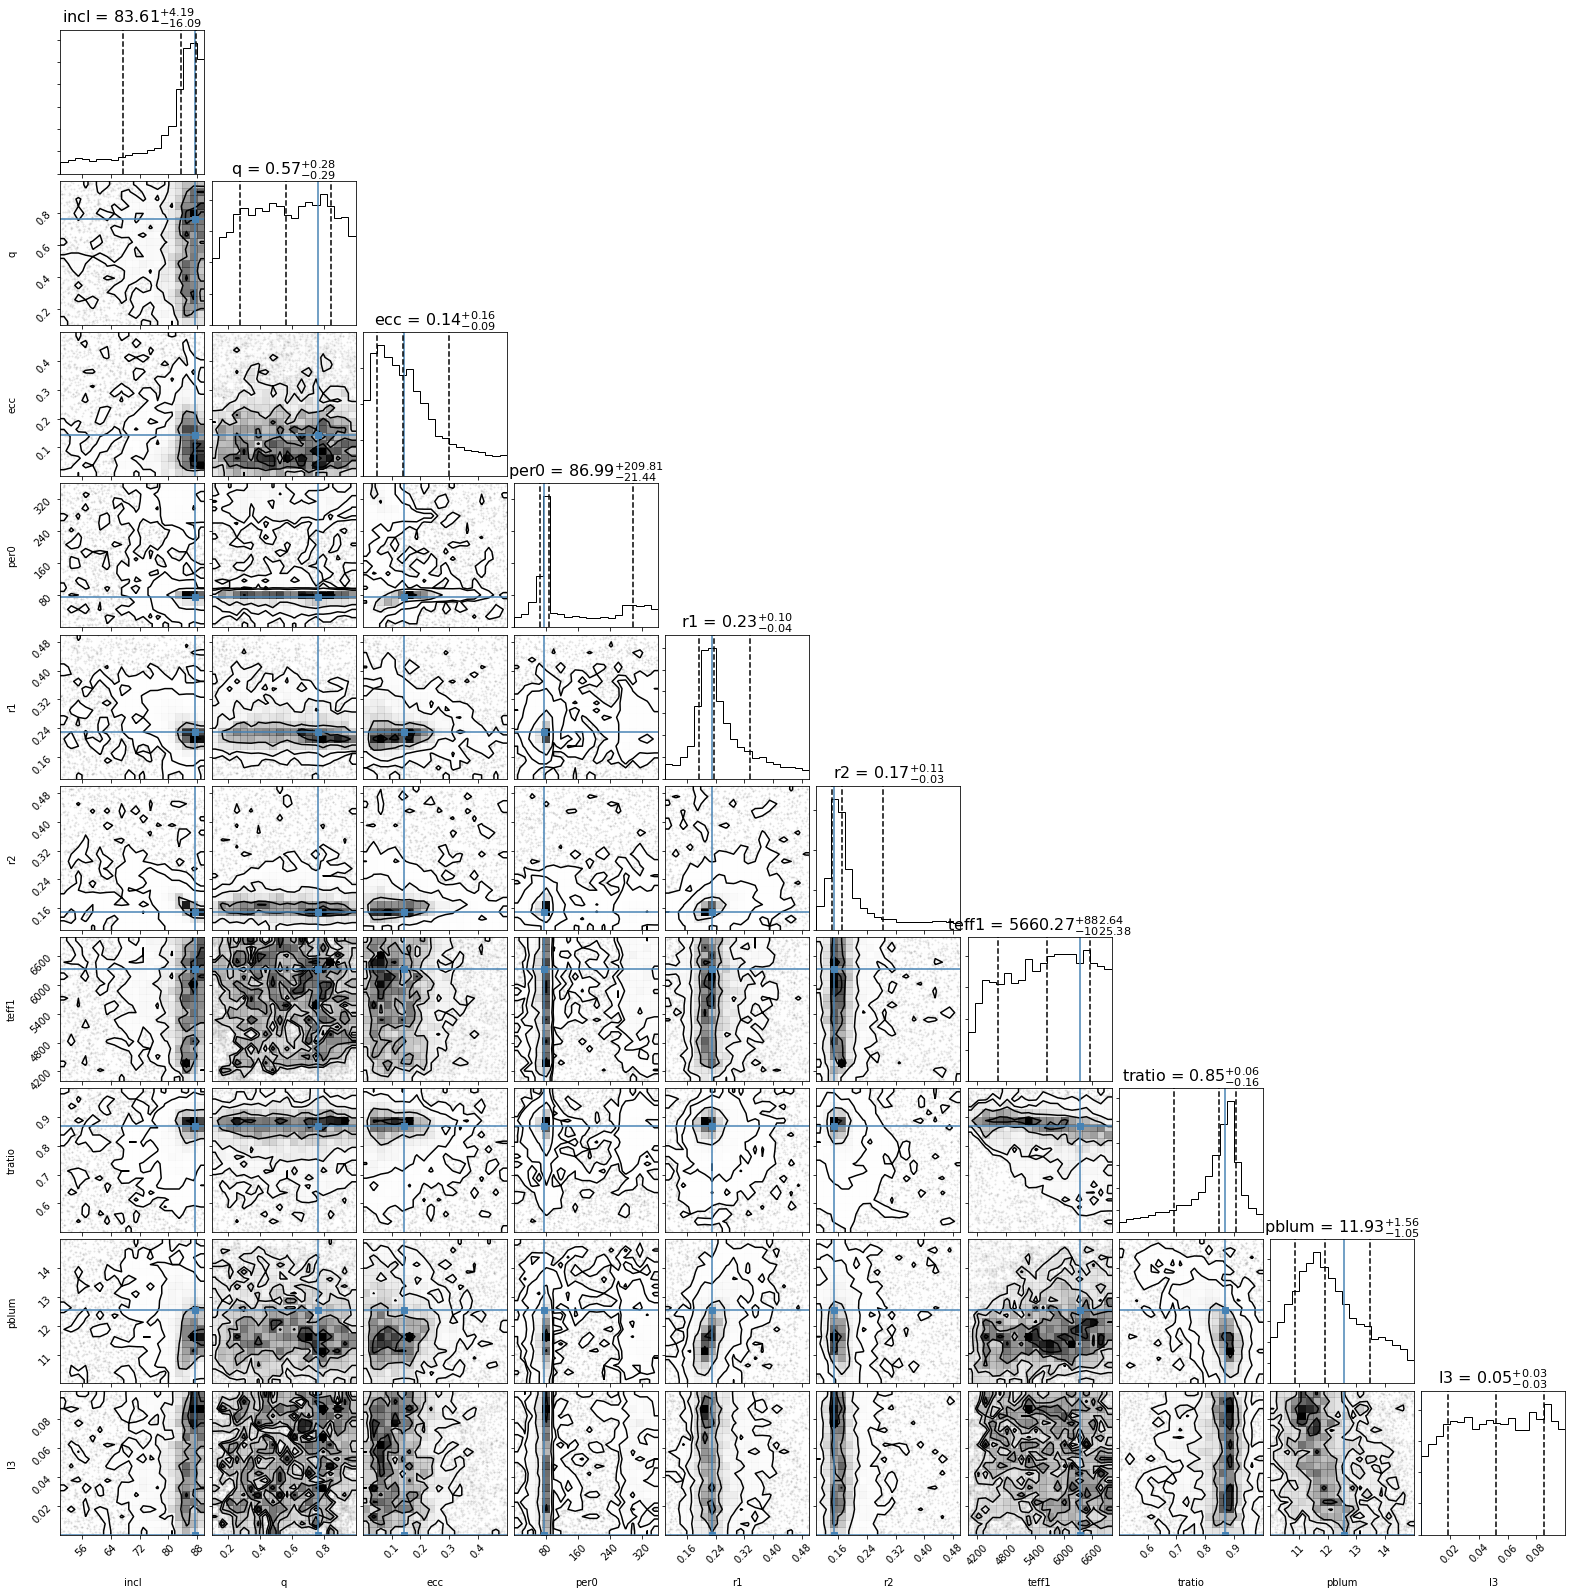

In [19]:
params = ['incl', 'q', 'ecc', 'per0', 'r1', 'r2', 'teff1', 'tratio', 'pblum', 'l3']
truths = [87.3, 0.765, 0.144, 76.3, 0.23, 0.1488, 6332, 0.8678, 12.5664, 0.0]
fig = corner.corner(samples[:7000], labels=params, quantiles=[0.16, 0.5, 0.84], truths=truths,
                       show_titles=True, title_kwargs={"fontsize": 16})